In [121]:
import pickle
import numpy as np
import pandas as pd
from os import listdir
from os.path import join, isfile

# data
table = 'regressor_5sgm_exp30m_z20_xy_flip.pickle'
path = '/data01/homes/dipiano/E4/irf_z20/crab/'
dataset = join(path, table)

# dataset 
if '.pickle' in table:
    with open(dataset,'rb') as f: ds = pickle.load(f)
    infotable = join(path, table.replace('.pickle', '.dat'))
elif '.npy' in table:
    ds = np.load(dataset, allow_pickle=True, encoding='latin1', fix_imports=True).flat[0]
    infotable = join(path, table.replace('.npy', '.dat'))


print(f"Maps: {ds.keys()}")
print(f"DS dataset size: {len(ds['DS'])}")

Maps: dict_keys(['DS', 'LABELS'])
DS dataset size: 20000


In [122]:
from astroai.tools.utils import split_regression_dataset

train_data, train_labels, test_data, test_labels = split_regression_dataset(ds, split=80, reshape=True, binning=200)

print(f"Train dataset: {len(train_data)}, {train_data.shape}")
print(f"Train labels: {len(train_labels)}, {train_labels.shape}")
print(f"\nTest dataset: {len(test_data)}, {test_data.shape}")
print(f"Test labels: {len(test_labels)}, {test_labels.shape}")

(16000, 200, 200) (16000, 2)
Train dataset: 16000, (16000, 200, 200, 1)
Train labels: 16000, (16000, 2)

Test dataset: 4000, (4000, 200, 200, 1)
Test labels: 4000, (4000, 2)


# Check 1 seed

In [123]:
import numpy as np
from astroai.tools.utils import plot_heatmap, set_wcs

# get random seed
idx = np.random.choice(range(len(train_data)))
# find seed to get the original heatmap
seed = idx + 1

# get simulation data
infodata = pd.read_csv(infotable, sep=' ', header=0).sort_values(by=['seed'])
row = infodata[infodata['seed']==seed]
row

,name,seed,start,stop,duration,source_ra,source_dec,point_ra,point_dec,offset,irf,fov,sim_time
1103,crab_09104,9104,0,100,100,82.792138,40.480853,81.43179,39.972405,1.156378,North_z20_0.5h_LST,2.5,6.436685


In [124]:
from astroai.tools.utils import *

binning = 200
pixelsize = (2 * row['fov'].values[0]) / binning
point_ref = (binning / 2) + (pixelsize / 2)
w = set_wcs(point_ra=row['point_ra'].values[0], point_dec=row['point_dec'].values[0], 
            point_ref=point_ref, pixelsize=pixelsize)

# TRUE
true_sky = SkyCoord(ra=row['source_ra'].values[0], dec=row['source_dec'].values[0], unit='deg', frame='icrs')
x, y = w.world_to_pixel(true_sky) 
true_sky = true_sky.ra.deg, true_sky.dec.deg
true_pix = x, y

# LABEL
label_pix = train_labels[idx][0] * binning, train_labels[idx][1] * binning
sky = w.pixel_to_world(label_pix[0], label_pix[1])
label_sky = sky.ra.deg, sky.dec.deg

print(f"TRUE TO PIX: {true_pix}")
print(f"LABEL: {label_pix}")
print(f"TRUE: {true_sky} ")
print(f"LABEL SKY: {label_sky}")

TRUE TO PIX: (array(57.63645824), array(119.67856782))
LABEL: (57.63645824098567, 119.67856782076024)
TRUE: (82.79213831271866, 40.48085319063413) 
LABEL SKY: (82.79213831271863, 40.48085319063413)


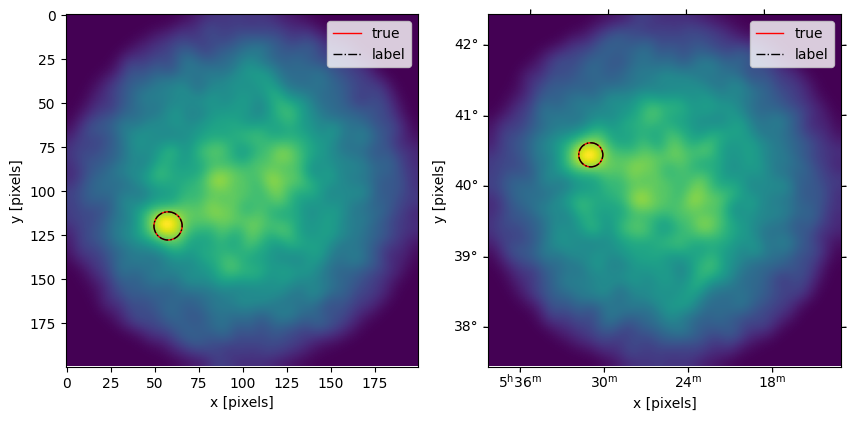

In [125]:
import astropy.units as u
from matplotlib.lines import Line2D

radius_deg = 0.2
radius_pix = radius_deg/0.025
figsize = (6, 6)

# PLOT
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(121), fig.add_subplot(122, projection=w)

# PIX
ax[0].imshow(train_data[idx], vmin=0, vmax=1)
ax[0].add_patch(plt.Circle((true_pix), radius=radius_pix, edgecolor='r', facecolor='none'))
ax[0].add_patch(plt.Circle((label_pix), radius=radius_pix, edgecolor='k', facecolor='none', ls='-.'))
ax[0].set_ylabel('y [pixels]')
ax[0].set_xlabel('x [pixels]')

# SKY
ax[1].imshow(train_data[idx], vmin=0, vmax=1)
ax[1].scatter(true_sky[0], true_sky[1], transform=ax[1].get_transform('icrs'), s=300,
               edgecolor='r', facecolor='none')
ax[1].scatter(label_sky[0], label_sky[1], transform=ax[1].get_transform('icrs'), s=300,
               edgecolor='k', facecolor='none', ls='-.')
ax[1].set_ylabel('y [pixels]')
ax[1].set_xlabel('x [pixels]')

# LEGENDS
custom_lines = [Line2D([0], [0], color='r', lw=1, ls='-'),
                Line2D([0], [0], color='k', lw=1, ls='-.')]
ax[0].legend(custom_lines, ['true', 'label'])
ax[1].legend(custom_lines, ['true', 'label'])

plt.show()